In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
from common.utils.pickling import pickle_read, pickle_write
from common.utils.misc import load_samples, load_sample_loss_csv, load_sample_losses
import matplotlib.pyplot as plt
import networkx as nx
from prepare_submission_data import pkl_to_tar
import re
from collections import defaultdict
import random

#### find "friends" - samples that have same topology and routing as given samples but different traffic

In [2]:
def get_same_topo_samples(samples):
    friends = defaultdict(list)

    for smp in samples:
        smp = Path(smp)
        smp_per_topo = int(re.search('_\d+x(\d+)_', smp.name)[1])
        ismp = int(smp.name.split('_')[-3])
        #     print(smp_per_topo, ismp, smp.name)

        i0 = ismp - (ismp%smp_per_topo)
        for i in range(i0, i0+smp_per_topo):
            iout = smp.parent / (smp.name.replace(f'_{ismp}_{ismp}_s_', f'_{i}_{i}_s_'))
            if iout.exists():
                friends[str(smp)].append(str(iout))

    print(f'found {sum(len(v) for v in friends.values())} samples')
    return friends

In [3]:
p_c2 = '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/submissions/2/Exp#10_2022-10-08__00-06-28'
p_c3 = '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/submissions/c3/Exp#34_2022-10-08__14-44-29'
c2_samples = load_samples(Path(p_c2)/'samples')
c3_samples = load_samples(Path(p_c3)/'samples')
c2c3 = c2_samples + [p for p in c3_samples if p not in c2_samples]
len(c2c3)

154

In [4]:
friends = get_same_topo_samples(c2c3)

found 1390 samples


In [8]:
pickle_write('/mnt/ext/users/yakovl/dev/GNNetworkingChallenge/subset_training/same_topo_as_6.7_samples.pkl', friends)

#### try improving 6.7 run with samples from the friends set

In [10]:
smp_loss = load_sample_loss_csv(Path(p_c3) / 'train_sample_loss_16-6.70.csv')
assert (smp_loss.path == c3_samples).all()
# indices of top-loss samples
toploss = smp_loss.loss.argsort()[::-1].reset_index(drop=True)
smp_loss.head()

,path,loss,flows,net_size,wloss,dset
0,/mnt/ext/shared/Projects/GNNetworkingChallenge...,8.584930,72,9,0.079347,hard3
1,/mnt/ext/shared/Projects/GNNetworkingChallenge...,4.898142,56,8,0.035211,15
2,/mnt/ext/shared/Projects/GNNetworkingChallenge...,4.008990,90,10,0.046317,8
3,/mnt/ext/shared/Projects/GNNetworkingChallenge...,16.132032,90,10,0.186378,hard3
4,/mnt/ext/shared/Projects/GNNetworkingChallenge...,18.407398,72,9,0.170133,hard4


In [20]:
# change the path
p_train_root = Path('/mnt/ext/users/yakovl/dev/GNNetworkingChallenge/subset_training/unshuffled_order/3/friends_6.7_2')
p_train_root.mkdir(parents=True)

<AxesSubplot:>

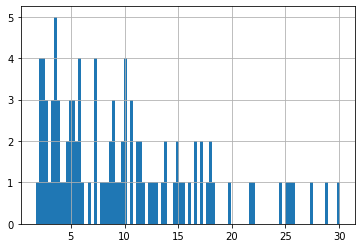

In [12]:
smp_loss.loss.hist(bins=100)

In [13]:
gp = {
    'hardest': smp_loss[smp_loss.loss>19],
    'hard': smp_loss[(smp_loss.loss>12) & (smp_loss.loss<=19)],
    'medium': smp_loss[(smp_loss.loss>7) & (smp_loss.loss<=12)],
    'easy': smp_loss[(smp_loss.loss>3) & (smp_loss.loss<=7)],
    'easiest': smp_loss[smp_loss.loss<=3],
}
for k, v in gp.items():
    print(k, v.shape)


hardest (10, 6)
hard (20, 6)
medium (28, 6)
easy (30, 6)
easiest (12, 6)


In [14]:
def sample_friends(friends, query, neach):
    ret = []
    for p in query.path:
        hf = [x for x in friends[p] if x != p]
        ret.extend(random.sample(friends[p], neach))
    return ret

def splice_to_end(samples, rm, add):
    keep = samples.drop(rm.index, axis=0)
    new100 = pd.concat((keep.path, pd.Series(add)))
    return new100

def splice_and_shuffle(samples, rm, add):
    keep = samples.drop(rm.index, axis=0)
    new100 = pd.concat((keep.path, pd.Series(add)))
    new100 = new100.sample(frac=1)
    return new100

def save_list(samples, save_dir):
    save_dir.mkdir()
    assert len(samples)==100
    samples.to_csv(save_dir / 'samples.txt', index=False, header=False)
    

In [21]:
# remove easiest and add friends of hardest
ntries = 3

save_root = p_train_root / f'repl_easiest_with_hardest_friends'
save_root.mkdir()

for n in [1, 3, 5]:
    for i in range(ntries):
        rm = gp['easiest'].sample(n)
        add = sample_friends(friends, gp['hardest'].sample(n), 1)
        new100 = splice_and_shuffle(smp_loss, rm, add)
        save_list(new100, save_root / f'n_{n}_{i}')


In [22]:
# remove easiest and add friends of single hardest
save_root = p_train_root / f'repl_easiest_with_1hardest_x_n'
save_root.mkdir()

hh = gp['hardest']
hh = hh[hh.path.apply(lambda x: len(friends[x]))>1]
for h in range(len(hh)):
    ihh = hh.iloc[i:i+1]
    n = 2
    for i in range(3):
        rm = gp['easiest'].sample(n)
        add = sample_friends(friends, ihh, n)
        new100 = splice_and_shuffle(smp_loss, rm, add)
        save_list(new100, save_root / f'h_{h}_n_{n}_{i}')


In [23]:
# replace hardest with their friends
ntries = 3

save_root = p_train_root / f'repl_hardest_with_friends'
save_root.mkdir()

hh = gp['hardest']
hh = hh[hh.path.apply(lambda x: len(friends[x]))>1]

for n in [1, 3, 5]:
    for i in range(ntries):
        rm = hh.sample(n)
        add = sample_friends(friends, rm, 1)
        new100 = splice_and_shuffle(smp_loss, rm, add)
        save_list(new100, save_root / f'n_{n}_{i}')


In [24]:
# replace hardest with friends of hard
ntries = 3

save_root = p_train_root / f'replace_hardest_with_hard_friends'
save_root.mkdir()

for n in [1, 3, 5]:
    for i in range(ntries):
        rm = gp['hardest'].sample(n)
        add = sample_friends(friends, gp['hard'].sample(n), 1)
        new100 = splice_and_shuffle(smp_loss, rm, add)
        save_list(new100, save_root / f'n_{n}_{i}')


In [25]:
# replace hardest with friends of medium
ntries = 3

save_root = p_train_root / f'replace_hardest_with_medium_friends'
save_root.mkdir()

for n in [1, 3, 5]:
    for i in range(ntries):
        rm = gp['hardest'].sample(n)
        add = sample_friends(friends, gp['medium'].sample(n), 1)
        new100 = splice_and_shuffle(smp_loss, rm, add)
        save_list(new100, save_root / f'n_{n}_{i}')


#### results

In [28]:
p_root = Path('/mnt/ext-10g/users/yakovl/dev/GNNetworkingChallenge/subset_training/unshuffled_order/3')
paths = list(p_root.glob('friends_6.7*/**/modelCheckpoints'))
print(len(paths), 'paths found')

126 paths found


In [48]:
results = []
for p in paths:
    exp = p.relative_to(p_root).parts[1]
    subexp = p.relative_to(p_root).parts[2]
    iresult = pd.read_csv(p.parent / 'val_eval.log').set_index('epoch')
    best = iresult.loc[iresult.loss.idxmin()]
    results.append({'path': str(p.parent),
                    'exp': exp,
                    'subexp': subexp,
                    'loss': best.loss,
                    'ckpt': best.ckpt,
                   })

results = pd.DataFrame(results).sort_values('loss')


In [49]:
results

,path,exp,subexp,loss,ckpt
72,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,repl_hardest_with_friends,n_3_0,6.6754,07-12.58
41,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,repl_easiest_with_1hardest_x_n,h_7_n_2_2,6.8827,20-9.75
75,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,repl_hardest_with_friends,n_5_2,7.0155,15-10.66
119,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,repl_easiest_with_1hardest_x_n,h_7_n_2_2,7.2304,14-9.44
80,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,repl_hardest_with_friends,n_3_2,7.2390,17-9.12
...,...,...,...,...,...
34,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,repl_hardest_with_friends,n_5_2,9.6630,02-20.31
125,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,repl_easiest_with_1hardest_x_n,h_1_n_2_0,9.6673,02-21.75
114,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,repl_easiest_with_1hardest_x_n,h_2_n_2_0,9.6887,20-4.33
84,/mnt/ext-10g/users/yakovl/dev/GNNetworkingChal...,replace_hardest_with_hard_friends,n_1_2,9.7552,10-7.49


In [51]:
exps = results.exp.unique()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

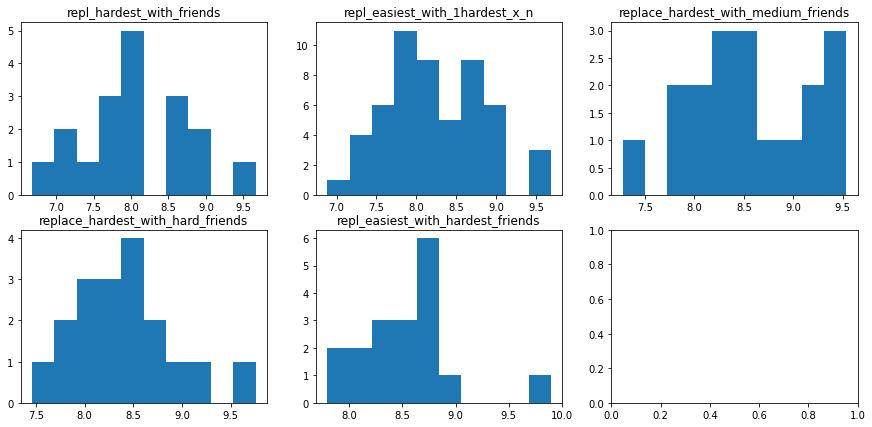

In [66]:
f, axx = plt.subplots(2,3, figsize=(15,7))
axx = np.concatenate((axx[0], axx[1]))
for i, exp in enumerate(results.exp.unique()):
    plt.sca(axx[i])
    plt.hist(results[results.exp == exp].loss)
    plt.title(exp)
    

In [70]:
for r in results.iloc[:5].itertuples():
    print(f'Loss {r.loss} {r.ckpt} {r.path}')
    
#results.iloc[:5][['path', 'loss', 'ckpt']]


Loss 6.6754 07-12.58 /mnt/ext-10g/users/yakovl/dev/GNNetworkingChallenge/subset_training/unshuffled_order/3/friends_6.7_2/repl_hardest_with_friends/n_3_0/n_3_0_2022-10-12__09-56-16
Loss 6.8827 20-9.75 /mnt/ext-10g/users/yakovl/dev/GNNetworkingChallenge/subset_training/unshuffled_order/3/friends_6.7/repl_easiest_with_1hardest_x_n/h_7_n_2_2/h_7_n_2_2_2022-10-11__21-42-56
Loss 7.0155 15-10.66 /mnt/ext-10g/users/yakovl/dev/GNNetworkingChallenge/subset_training/unshuffled_order/3/friends_6.7_2/repl_hardest_with_friends/n_5_2/n_5_2_2022-10-12__09-56-16
Loss 7.2304 14-9.44 /mnt/ext-10g/users/yakovl/dev/GNNetworkingChallenge/subset_training/unshuffled_order/3/friends_6.7_2/repl_easiest_with_1hardest_x_n/h_7_n_2_2/h_7_n_2_2_2022-10-12__09-56-17
Loss 7.239 17-9.12 /mnt/ext-10g/users/yakovl/dev/GNNetworkingChallenge/subset_training/unshuffled_order/3/friends_6.7_2/repl_hardest_with_friends/n_3_2/n_3_2_2022-10-12__09-56-15
